# Stock price prediction using LSTM neural network and Tensorflow
What do we need here:
1. Load data
2. Scale data for machine learning model
3. Setup neural network
4. Compile model
5. Teach neural netowk and fit this
6. Use the model for prediction
7. Draw the results chart

In [ ]:
# Requirements
!pip install yahoo_fin

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.1/81.1 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.4/83.4 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.1/143.1 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 8.9 MB/s eta 0:00:00
  Created wheel for bs4: filename=bs4-0.0.1-py3-none-any.whl size=1256 sha256=2c0a2f9ded61d038c9984ba71b6c05541f23f6a1028ee5ae23d9d477b121f2b8
  Stored in directory: /root/.cache/pip/wheels/25/42/45/b773edc52acb16cd2db4cf1a0b47117e2f69bb4eb300ed0e70
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6048 sha256=9c358f094132c0a4c7e707c307c2d2906251f43ce2dd0aeb22ad65ff7e72f755
  Stored in directory: /root/.cache/pip/wheels/f0/69/93/a47e9d621be168e9e33c7ce60524393c0b92ae83cf6c6e89c5
Successfully built bs4 sgmllib3k
  Attempting uninstall: urllib3
    Found existing 

In [ ]:
import numpy as np
import time as tm
import datetime as dt
import tensorflow as tf

# Data preparation
from yahoo_fin import stock_info as yf
from sklearn.preprocessing import MinMaxScaler
from collections import deque

# AI
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

# Graphics library
import matplotlib.pyplot as plt

In [ ]:
# SETTINGS

# Window size or the sequence length, 7 (1 week)
N_STEPS = 7

# Lookup steps, 1 is the next day, 3 = after tomorrow
LOOKUP_STEPS = [1, 2, 3]

# Stock ticker, GOOGL
STOCK = 'GOOGL'

# Current date
date_now = tm.strftime('%Y-%m-%d')
date_3_years_back = (dt.date.today() - dt.timedelta(days=1104)).strftime('%Y-%m-%d')

In [ ]:
# LOAD DATA
# from yahoo_fin
# for 1104 bars with interval = 1d (one day)
init_df = yf.get_data(
    STOCK,
    start_date=date_3_years_back,
    end_date=date_now,
    interval='1d')

In [ ]:
init_df

,open,high,low,close,adjclose,volume,ticker
2020-08-10,74.540001,75.357498,73.874496,74.841003,74.841003,20546000,GOOGL
2020-08-11,74.699997,75.522003,73.909500,74.027000,74.027000,31098000,GOOGL
2020-08-12,74.356003,75.583504,74.250000,75.362000,75.362000,22512000,GOOGL
2020-08-13,75.410500,76.848503,75.410500,75.832497,75.832497,22388000,GOOGL
2020-08-14,75.680496,75.989502,74.949997,75.231499,75.231499,21942000,GOOGL
...,...,...,...,...,...,...,...
2023-08-14,129.389999,131.369995,128.960007,131.330002,131.330002,24695600,GOOGL
2023-08-15,131.100006,131.419998,129.279999,129.779999,129.779999,19770700,GOOGL
2023-08-16,128.699997,130.279999,127.870003,128.699997,128.699997,25216100,GOOGL
2023-08-17,129.800003,131.990005,129.289993,129.919998,129.919998,33446300,GOOGL


In [ ]:
# remove columns which our neural network will not use
init_df = init_df.drop(['open', 'high', 'low', 'adjclose', 'ticker', 'volume'], axis=1)
# create the column 'date' based on index column
init_df['date'] = init_df.index

In [ ]:
init_df

,close,date
2020-08-10,74.841003,2020-08-10
2020-08-11,74.027000,2020-08-11
2020-08-12,75.362000,2020-08-12
2020-08-13,75.832497,2020-08-13
2020-08-14,75.231499,2020-08-14
...,...,...
2023-08-14,131.330002,2023-08-14
2023-08-15,129.779999,2023-08-15
2023-08-16,128.699997,2023-08-16
2023-08-17,129.919998,2023-08-17


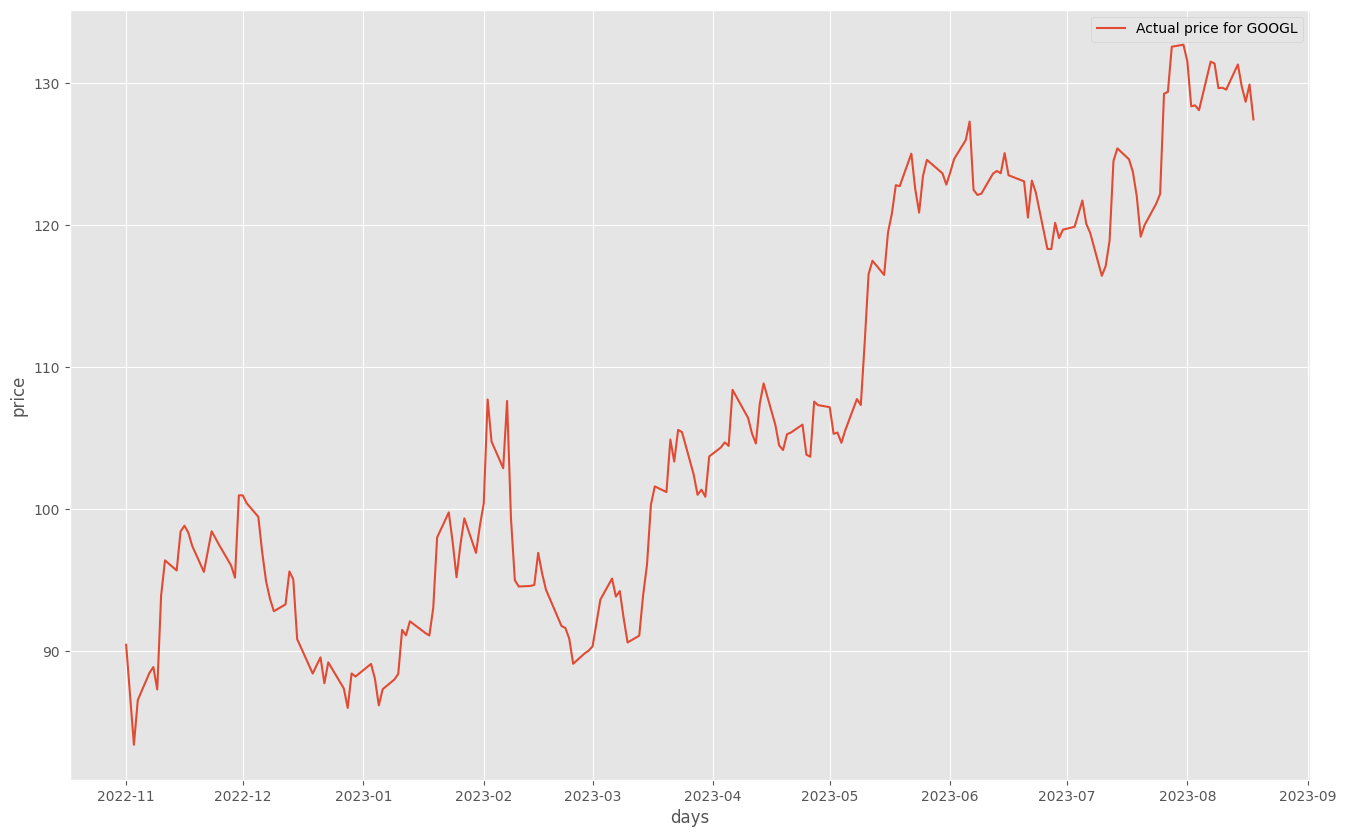

In [ ]:
# Let's preliminary see our data on the graphic
plt.style.use(style='ggplot')
plt.figure(figsize=(16,10))
plt.plot(init_df['close'][-200:])
plt.xlabel('days')
plt.ylabel('price')
plt.legend([f'Actual price for {STOCK}'])
plt.show()

In [ ]:
# Scale data for ML engine
scaler = MinMaxScaler()
init_df['scaled_close'] = scaler.fit_transform(np.expand_dims(init_df['close'].values, axis=1))

In [ ]:
init_df

,close,date,scaled_close
2020-08-10,74.841003,2020-08-10,0.055078
2020-08-11,74.027000,2020-08-11,0.044822
2020-08-12,75.362000,2020-08-12,0.061642
2020-08-13,75.832497,2020-08-13,0.067570
2020-08-14,75.231499,2020-08-14,0.059998
...,...,...,...
2023-08-14,131.330002,2023-08-14,0.766804
2023-08-15,129.779999,2023-08-15,0.747275
2023-08-16,128.699997,2023-08-16,0.733668
2023-08-17,129.919998,2023-08-17,0.749039


In [ ]:
def PrepareData(days):
  df = init_df.copy()
  df['future'] = df['scaled_close'].shift(-days)
  last_sequence = np.array(df[['scaled_close']].tail(days))
  df.dropna(inplace=True)
  sequence_data = []
  sequences = deque(maxlen=N_STEPS)

  for entry, target in zip(df[['scaled_close'] + ['date']].values, df['future'].values):
      sequences.append(entry)
      if len(sequences) == N_STEPS:
          sequence_data.append([np.array(sequences), target])

  last_sequence = list([s[:len(['scaled_close'])] for s in sequences]) + list(last_sequence)
  last_sequence = np.array(last_sequence).astype(np.float32)

  # construct the X's and Y's
  X, Y = [], []
  for seq, target in sequence_data:
      X.append(seq)
      Y.append(target)

  # convert to numpy arrays
  X = np.array(X)
  Y = np.array(Y)

  return df, last_sequence, X, Y

In [ ]:
PrepareData(3) # 3 days

(                 close       date  scaled_close    future
 2020-08-10   74.841003 2020-08-10      0.055078  0.067570
 2020-08-11   74.027000 2020-08-11      0.044822  0.059998
 2020-08-12   75.362000 2020-08-12      0.061642  0.067312
 2020-08-13   75.832497 2020-08-13      0.067570  0.092221
 2020-08-14   75.231499 2020-08-14      0.059998  0.085184
 ...                ...        ...           ...       ...
 2023-08-09  129.660004 2023-08-09      0.745764  0.766804
 2023-08-10  129.690002 2023-08-10      0.746141  0.747275
 2023-08-11  129.559998 2023-08-11      0.744503  0.733668
 2023-08-14  131.330002 2023-08-14      0.766804  0.749039
 2023-08-15  129.779999 2023-08-15      0.747275  0.718045
 
 [759 rows x 4 columns],
 array([[0.7693243 ],
        [0.7676863 ],
        [0.7457635 ],
        [0.7461415 ],
        [0.7445035 ],
        [0.76680446],
        [0.74727535],
        [0.733668  ],
        [0.7490393 ],
        [0.7180448 ]], dtype=float32),
 array([[[0.0550782491372245

In [ ]:
def GetTrainedModel(x_train, y_train):
  model = Sequential()
  model.add(LSTM(60, return_sequences=True, input_shape=(N_STEPS, len(['scaled_close']))))
  model.add(Dropout(0.3))
  model.add(LSTM(120, return_sequences=False))
  model.add(Dropout(0.3))
  model.add(Dense(20))
  model.add(Dense(1))

  BATCH_SIZE = 8
  EPOCHS = 80

  model.compile(loss='mean_squared_error', optimizer='adam')

  model.fit(x_train, y_train,
            batch_size=BATCH_SIZE,
            epochs=EPOCHS,
            verbose=1)

  model.summary()

  return model

In [ ]:
# GET PREDICTIONS
predictions = []

for step in LOOKUP_STEPS:
  df, last_sequence, x_train, y_train = PrepareData(step)
  x_train = x_train[:, :, :len(['scaled_close'])].astype(np.float32)

  model = GetTrainedModel(x_train, y_train)

  last_sequence = last_sequence[-N_STEPS:]
  last_sequence = np.expand_dims(last_sequence, axis=0)
  prediction = model.predict(last_sequence)
  predicted_price = scaler.inverse_transform(prediction)[0][0]

  predictions.append(round(float(predicted_price), 2))

Epoch 1/80
95/95 [==============================] - 7s 15ms/step - loss: 0.0168
Epoch 2/80
95/95 [==============================] - 1s 15ms/step - loss: 0.0048
Epoch 3/80
95/95 [==============================] - 1s 15ms/step - loss: 0.0048
Epoch 4/80
95/95 [==============================] - 1s 14ms/step - loss: 0.0051
Epoch 5/80
95/95 [==============================] - 2s 16ms/step - loss: 0.0042
Epoch 6/80
95/95 [==============================] - 3s 32ms/step - loss: 0.0039
Epoch 7/80
95/95 [==============================] - 2s 22ms/step - loss: 0.0047
Epoch 8/80
95/95 [==============================] - 2s 20ms/step - loss: 0.0035
Epoch 9/80
95/95 [==============================] - 1s 15ms/step - loss: 0.0031
Epoch 10/80
95/95 [==============================] - 1s 15ms/step - loss: 0.0030
Epoch 11/80
95/95 [==============================] - 1s 15ms/step - loss: 0.0028
Epoch 12/80
95/95 [==============================] - 1s 15ms/step - loss: 0.0028
Epoch 13/80
95/95 [==================

In [ ]:
if bool(predictions) == True and len(predictions) > 0:
  predictions_list = [str(d)+'$' for d in predictions]
  predictions_str = ', '.join(predictions_list)
  message = f'{STOCK} prediction for upcoming 3 days ({predictions_str})'

  print(message)

GOOGL prediction for upcoming 3 days (128.67$, 129.28$, 128.83$)


In [ ]:
# Execute model for the whole history range
copy_df = init_df.copy()
y_predicted = model.predict(x_train)
y_predicted_transformed = np.squeeze(scaler.inverse_transform(y_predicted))
first_seq = scaler.inverse_transform(np.expand_dims(y_train[:6], axis=1))
last_seq = scaler.inverse_transform(np.expand_dims(y_train[-3:], axis=1))
y_predicted_transformed = np.append(first_seq, y_predicted_transformed)
y_predicted_transformed = np.append(y_predicted_transformed, last_seq)
copy_df[f'predicted_close'] = y_predicted_transformed

24/24 [==============================] - 0s 7ms/step


In [ ]:
copy_df

,close,date,scaled_close,predicted_close
2020-08-10,74.841003,2020-08-10,0.055078,78.778503
2020-08-11,74.027000,2020-08-11,0.044822,79.257500
2020-08-12,75.362000,2020-08-12,0.061642,80.292503
2020-08-13,75.832497,2020-08-13,0.067570,82.206497
2020-08-14,75.231499,2020-08-14,0.059998,81.426003
...,...,...,...,...
2023-08-14,131.330002,2023-08-14,0.766804,130.942810
2023-08-15,129.779999,2023-08-15,0.747275,130.404831
2023-08-16,128.699997,2023-08-16,0.733668,128.699997
2023-08-17,129.919998,2023-08-17,0.749039,129.919998


In [ ]:
# Add predicted results to the table
date_now = dt.date.today()
date_tomorrow = dt.date.today() + dt.timedelta(days=1)
date_after_tomorrow = dt.date.today() + dt.timedelta(days=2)

copy_df.loc[date_now] = [predictions[0], f'{date_now}', 0, 0]
copy_df.loc[date_tomorrow] = [predictions[1], f'{date_tomorrow}', 0, 0]
copy_df.loc[date_after_tomorrow] = [predictions[2], f'{date_after_tomorrow}', 0, 0]

<ipython-input-18-ca1349af6c77>:7: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  copy_df.loc[date_tomorrow] = [predictions[1], f'{date_tomorrow}', 0, 0]
<ipython-input-18-ca1349af6c77>:8: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  copy_df.loc[date_after_tomorrow] = [predictions[2], f'{date_after_tomorrow}', 0, 0]


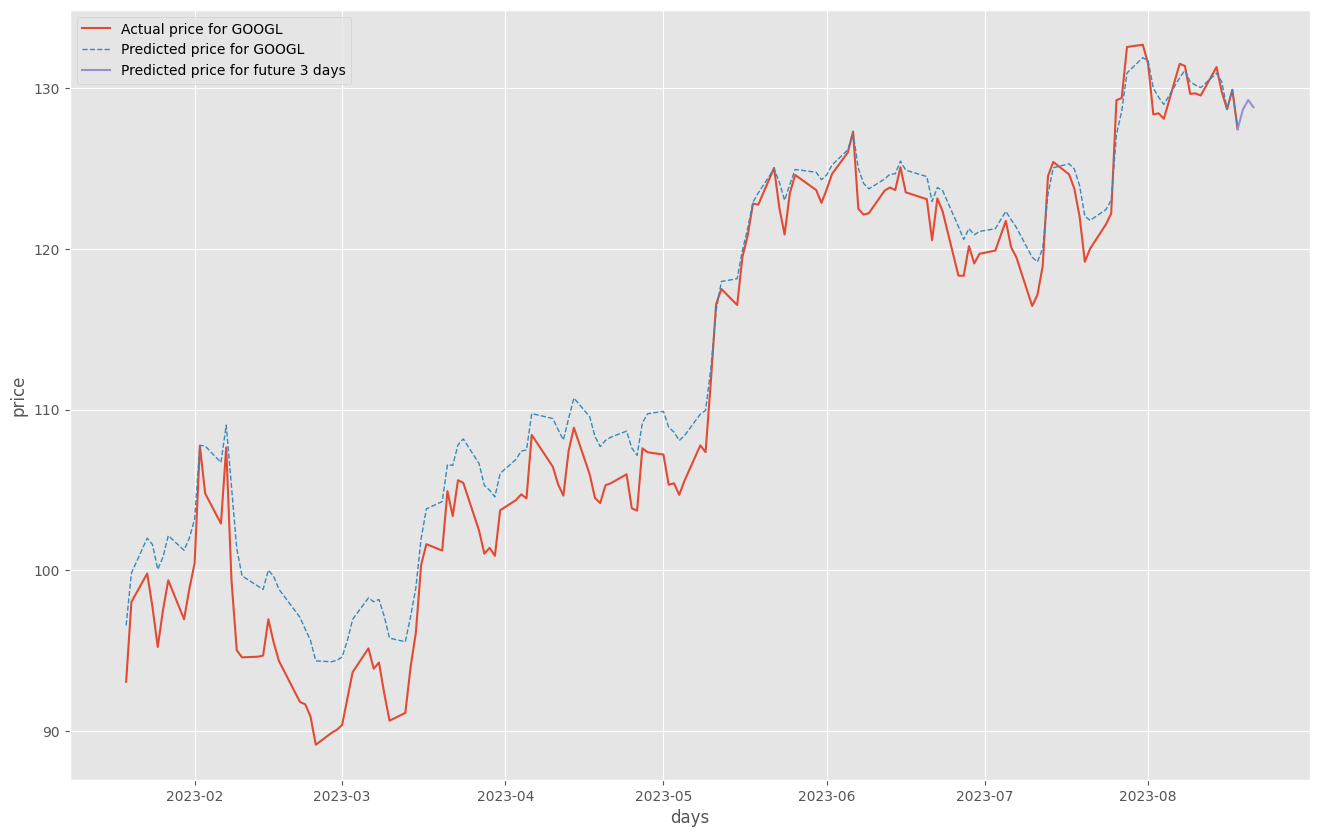

In [ ]:
# Result chart
plt.style.use(style='ggplot')
plt.figure(figsize=(16,10))
plt.plot(copy_df['close'][-150:].head(147))
plt.plot(copy_df['predicted_close'][-150:].head(147), linewidth=1, linestyle='dashed')
plt.plot(copy_df['close'][-150:].tail(4))
plt.xlabel('days')
plt.ylabel('price')
plt.legend([f'Actual price for {STOCK}',
            f'Predicted price for {STOCK}',
            f'Predicted price for future 3 days'])
plt.show()